<div align='center'><font size="5" color='#088a5a'>Unlocking Insights from CDP Surve Data: Measuring Sustainability
</font></div>
<div align='center'><font size="4" color="#088a5a">A detailed comparative analysis on the future of eco-KPIs</font></div>
<hr>

<p>The measurement of what we call a city’s ‘sustainability’ has also changed greatly over time. We might say that sustainability used to be about measuring the level of pollution and the amount of parkland. In the 1990s, many cities began to take a new approach to balancing their environmental, social and economic impact, using metrics not only to measure factors such as energy, water use and pollution but also to address concerns such as crime, employment and health. With the exploding amount of urban data, the metrics have become more complex, and their uses have expanded, particularly as the government addresses a wider range of environmental and social needs. When we measure cities now, we are seeking to understand them in order to manage them better and to provide evidence of performance. Increasingly, we measure cities to understand their sustainability and to make decisions that will allow those who live in them to be happier and healthier in the future. 
 </p>

<img src='https://i2.wp.com/wearerestless.org/wp-content/uploads/2016/11/HiRes.jpg?zoom=2&resize=1155%2C770&ssl=1' width=500>
<div align="center"><font size="2">Source: wearerestless.org</font></div>  

 
A carefully selected and relatively small number of easily understandable Key Performance Indicators (KPI) is useful for city managers to get a snapshot of the city's performance in different areas. The question of interest in this analysis is: **does setting up plans/targets promote sustainability performance?**






<font color='#088a5a' size=5>Contents</font><br>

<a href="#1">1. Lessons from Working with Survey Data</a>   
<a href="#2">2. Modified Green City Index (MGCI): Constructing 8 Axes from CDP Survey</a>  
<a href="#3">3. Analysis on Corporate + City: CDP Answer Mining</a>   
<a href="#4">4. Does setting up plans/targets promote sustainability performance?</a>   
<a href="#5">5. Concluding Remarks: Actionable Insights</a>   
<a href="#6">6. References</a>  

<div id="#1"></div>
<font color='#088a5a' size=5>1. Lessons from Working with Survey Data</font><br>            

In this section, we start with looking at 2 dimensions of city development strategy by analyzing 2 specific questions from the city survey.


In [ ]:
# standard libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# plotting libs
import seaborn as sns

# geospatial libs
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import geopandas as gpd
import folium
import plotly.graph_objects as go
import plotly_express as px

# set in line plotly 
from plotly.offline import init_notebook_mode;
init_notebook_mode(connected=True)

In [ ]:
# import corporate response data
cc_df = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv',dtype={"Response Answer":"string","comments": "string"})
ws_df = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Water Security/2020_Full_Water_Security_Dataset.csv',dtype={"comments": "string"})
cc_df = pd.concat([cc_df, ws_df],ignore_index=True)
cc_df.rename(columns = {'question_unique_reference':'Question Name','response_value':'Response Answer'}, inplace = True)

# import city responses
city_df = pd.read_csv('../input/cdp-unlocking-climate-solutions/Cities/Cities Responses/2020_Full_Cities_Dataset.csv',dtype={"Response Answer":"string","comments": "string"})
city_df = city_df.fillna('Do not know')

In [ ]:
qs_city = city_df['Question Name'].unique()
qs = qs_city

In [ ]:
def get_q(df = city_df, keyword = ""):
    qs = df['Question Name'].unique()
    matching = [(i,s) for i,s in enumerate(qs) if keyword in s]
    return matching

def get_ans(df, qnum):
    qs = df['Question Name'].unique()
    return df[df["Question Name"] == qs[qnum]]["Response Answer"]

def combine_ans(df, phrase):
    sep = []
    if type(phrase) == list:
        # set of answers that contain all phrases
        for p in phrase:
            tmp = [i[0] for i in get_q(df,p)]
            sep.append(tmp)
        q_num = set.intersection(*map(set,sep))
            
    else:
        q_num = [i[0] for i in get_q(df,phrase)]
        
    ans_list = []
    for q in q_num:
        ans_list.append(' '.join([i for i in list(get_ans(df, q).unique()) if type(i) == str]))

    all_ans = ' '.join([str(elem) for elem in ans_list]) 
    all_ans = all_ans.replace("Other, please specify:"," ")
    return all_ans

def generate_wraptxt(txt, linewidth=40): 
    tit = wrap(txt, width=linewidth)
    return '\n'.join(tit)

In [ ]:
q1='Does your city incorporate sustainability goals and targets (e.g. GHG reductions) into the master planning for the city?'
q2 = 'Does your city collaborate in partnership with businesses in your city on sustainability projects?'

In [ ]:
pref_color = [ '#9FF781','#CEF6D8',  '#F7819F', '#F5A9BC','#E6E6E6']
dds = [city_df.groupby('Question Name').get_group(q1)["Response Answer"].value_counts(),\
      city_df.groupby('Question Name').get_group(q2)["Response Answer"].value_counts()]
q = [q1, q2]

for i,dd in enumerate(dds):
    xx = list(dd.keys())

    # matplotlib general settings
    fig, ax = plt.subplots(figsize=(20,1))
    plt.title(q[i], fontsize=18, loc='left')
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', labelsize=16, labelcolor='grey')  
    ax.set_facecolor('white')
    ax.axis('off')
    # Draw each bar and text separately with appropriate offset
    bar_start = 0
    cnts = [dd[_]/np.sum(list(dd.values)) for _ in xx]

    for i in range(len(dd)):
        ax.barh(y=['All Respondents'], width=cnts[i], height=0.1, left=bar_start, color=pref_color[i])
        plt.text(bar_start + cnts[i]/2 - 0.01, -0.01, "{:.0%}".format(cnts[i]), fontsize=16)
        bar_start += cnts[i]

#     Draw legend and set color of its text
    leg = ax.legend(xx, loc=(0,-0.5), ncol=5, fontsize=14, frameon=True, facecolor='white');
    for txt in leg.get_texts():
        plt.setp(txt, color='grey')

In [ ]:
from textwrap import wrap
barcolors = ["#fad46b","#97c6e8"]
barstyle = {"edgecolor":"black", "linewidth":0.5}

# build a city questions df
d =  {'city': city_df['Organization'].unique()}
df_cityQ = pd.DataFrame(data = d)
mapping_country = dict(city_df[['Organization', 'Country']].values)
df_cityQ['Country'] = df_cityQ['city'].map(mapping_country)

q = {'q1': q1, 'q2':q2}
for k,val in q.items():
    options = city_df.groupby('Question Name').get_group(val)["Response Answer"].value_counts().keys()
    options_map = {}
    for i in np.arange(len(options)):
        options_map[options[i]] = i

    df_cityQ[k] = pd.DataFrame(city_df.groupby('Question Name').get_group(val)["Response Answer"]).reset_index(drop = True)
#     df_cityQ[k] = df_cityQ[k].map(options_map) # convert to numeric values

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles

plt.figure(figsize=(6,6))
vd3=venn3([set(df_cityQ[df_cityQ['q1'] == 'Yes']['city']), set(df_cityQ[df_cityQ['q2'] == 'Yes']['city']),\
      set(df_cityQ['city'])],
 set_labels= ('Cities incorporating \n sustainability goal',\
                    'Cities collaborating with businesses \n on sustainability projects','All cities'),
 set_colors=('#c4e6ff', '#F4ACB7','#9D8189'), 
 alpha = 0.8)

c=venn3_circles([set(df_cityQ[df_cityQ['q1'] == 'Yes']['city']), set(df_cityQ[df_cityQ['q2'] == 'Yes']['city']),\
      set(df_cityQ['city'])], linestyle='-.', linewidth=2, color='grey')
for text in vd3.set_labels:
    text.set_fontsize(16);
# for text in vd3.subset_labels:
#     text.set_fontsize(16)
plt.title('Comparison of city responses: Sustainability development',fontname='Times New Roman',fontweight='bold',fontsize=20,
 pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');

plt.annotate('Planning-first', xy=(-0.3,-0.3), xytext=(0.05,0.1),
ha='center', textcoords= 'axes fraction', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
arrowprops=dict(arrowstyle='<-', connectionstyle='arc3,rad=0.5',color='gray'))

plt.annotate('Collaborating-first', xy=(0.4,0.2), xytext=(1.2,0.3),
ha='center', textcoords= 'axes fraction', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
arrowprops=dict(arrowstyle='<-', connectionstyle='arc3,rad=0.5',color='gray'))

plt.annotate('Planning and Collaborating interrelated', xy=(0.1,-0.2), xytext=(1.1,0.1),
ha='center', textcoords= 'axes fraction', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
arrowprops=dict(arrowstyle='<-', connectionstyle='arc3,rad=0.5',color='gray'))

plt.show()

While proactive environmental initiatives may create an unique edge, such strategy requires substantial resources, management capabilities and long-term commitment. To achieve this, some cities may choose to cooperate with firms, by pooling resources to create synergies and innovative strategies to boost sustainability. The Venn Diagram above shows the number of cities that take different development strategies.

In [ ]:
from matplotlib import cm
heatmap_args = dict(annot=True, fmt="d", square=False, cmap=cm.get_cmap("Greens",12), 
               center = 90, vmin=0, vmax=500, lw=4, 
               cbar=False)
def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_border_around_axes(this_ax, color="black"):
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color(color)
        
def draw_code_ml_heatmap_general(df,tmp_ax,**kwargs):
    hm = sns.heatmap(df, ax = tmp_ax, 
                **kwargs)
    tmp_ax.set_xlabel('Q1')
    tmp_ax.set_ylabel('Q2')
    tmp_ax.set_yticklabels(tmp_ax.get_yticklabels(), rotation=0);
    return hm 
    
def draw_code_ml_heatmap(tmp_ax):
    hm = draw_code_ml_heatmap_general(allage_codepivot2, tmp_ax, **heatmap_args)
    return hm

def calc_df_hist(df):
    return df/df.sum().sum()

def draw_mini_heatmap(df, this_ax, titletxt, linewidth=25, **kwargs):
    hm = draw_code_ml_heatmap_general(df, this_ax, **kwargs)
    this_ax.set_title(generate_wraptxt(titletxt, linewidth));
    this_ax.set_frame_on(True)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    this_ax.set_xlabel('')
    this_ax.set_ylabel('')
    draw_border_around_axes(this_ax)
    return hm 

In [ ]:
heatmap_args_nolim = dict(annot=True, fmt="d", square=False, cmap=cm.get_cmap("Greens",12), 
               lw=4, cbar=False)
heatmap_args_ref = heatmap_args_nolim.copy()
heatmap_args_ref['square']=True
heatmap_args_ref['annot']=True
heatmap_args_ref['fmt']='.0f'
heatmap_args_ref['cmap']=cm.get_cmap('Greens')
heatmap_args_ref['center']=13
heatmap_args_ref['vmax']=25
heatmap_args_ref['vmin']=0
heatmap_args_ref['annot_kws']={"size":7}

heatmap_args_nolim_sq = heatmap_args_nolim.copy()
heatmap_args_nolim_sq['square']=True
heatmap_args_nolim_sq['annot']=False
heatmap_args_nolim_sq['fmt']='.1%'
heatmap_args_nolim_sq['cmap']=cm.get_cmap('seismic_r',11)
heatmap_args_nolim_sq['center']=0
heatmap_args_nolim_sq['vmax']=0.055
heatmap_args_nolim_sq['vmin']=-0.055


In [ ]:
df_cityQ = df_cityQ.replace("", "Do not know")
allage_codepivot2 = pd.crosstab(df_cityQ['q1'], df_cityQ['q2'])
prefer_order = [0,3,2,1,4]
allage_codepivot2 = allage_codepivot2[allage_codepivot2.columns[prefer_order]]
# allage_codepivot2 = allage_codepivot2.reindex(['Do not know','Not intending to incorporate','Intending to incorporate in the next 2 years','In progress','Yes'])
allage_codepivot2 = allage_codepivot2.reindex(allage_codepivot2.index[prefer_order])

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

this_ax = ax[0,0]
hide_axes(this_ax)

hm_ax = ax[1,1]
draw_code_ml_heatmap(hm_ax);
hm_ax.yaxis.tick_right()
hm_ax.yaxis.set_label_position("right")
draw_border_around_axes(hm_ax)

this_ax = ax[0,1]
allage_codepivot2.sum(axis=0).plot.bar(ax=this_ax, color=barcolors[1],**barstyle)
this_ax.set_xlabel(hm_ax.get_xlabel())
this_ax.xaxis.set_ticklabels([])
# this_ax.xaxis.tick_top()
this_ax.xaxis.set_label_position("top")
this_ax.set_ylabel('# answers')

this_ax = ax[1,0]
allage_codepivot2.sum(axis=1)[::-1].plot.barh(ax=this_ax, color=barcolors[0],**barstyle)
this_ax.set_ylabel(hm_ax.get_ylabel())
this_ax.yaxis.set_label_position("left")
# this_ax.xaxis.tick_top()
# this_ax.xaxis.set_label_position("top")
# this_ax.set_xlim(this_ax.get_xlim()[::-1]);
this_ax.set_xlabel('# answers');
print("Q1: "+ q1)
print("Q2: " + q2)

Interpreting the heatmap:
Overall, this heatmap above illustrates the distribution of specific clusters of survey takers when it comes to their development priorities. The degree gets higher rightwards and downwards.

More specificlly,
 - the upper left to lower right diagonal suggests both incorporating sustainability goals and targets into city master planning and collaborating in partnership with businesses at equal weight
 - below the diagonal suggests more focus on collaborations
 - above the diagonal are cities that focus more on planning

In [ ]:
refhist = calc_df_hist(allage_codepivot2)
this_ax = plt.axes()
rh = refhist
heatmap_args_ref2 = heatmap_args_ref.copy()
heatmap_args_ref2['annot_kws'] = {"size":10}
draw_mini_heatmap(
        round((rh)*100), 
        this_ax, "Across all surveyed cities (%)", **heatmap_args_ref2);

Here, we simply normalize the heatmap to percentages.

In [ ]:
# horizontal comparison
f, ax = plt.subplots(ncols=3, nrows=1, figsize = (12,4),
                     gridspec_kw = {"wspace":0.75})

this_ax = ax[0]
draw_mini_heatmap(
        round((refhist)*100), 
        this_ax, "across all cities (%)", **heatmap_args_ref2)

for i, country_name in enumerate(['United States of America', "Mexico"]):
    dat = pd.crosstab(df_cityQ.query('Country == @country_name')['q1'], \
                     df_cityQ.query('Country == @country_name')['q2'])
    dat = dat.reindex(index=df_cityQ['q1'].unique()[[4,3,2,1,0]], \
                      columns=df_cityQ['q2'].unique()[[4,3,2,1,0]], fill_value=0)
    st = calc_df_hist(dat)
    this_ax = ax[i+1]
    draw_mini_heatmap(
            round((st)*100), 
            this_ax, country_name, **heatmap_args_ref2)

We could compare horizontally the heatmaps for cities from different countries relative to the average across all cities surveyed.

In [ ]:
import matplotlib.patheffects as path_effects
def black_border_around_text(annotation_handle):
    annotation_handle.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
    return annotation_handle

def draw_zero_heatmap_legend(this_ax, cbar_ax, df):
    cbar_kws = dict(orientation="horizontal", ticks=np.arange(-0.06,0.06,0.01))    
    cbar_pos = cbar_ax.get_position()
    cbar_ax.set_position([cbar_pos.x0, cbar_pos.y0+cbar_pos.height/2, cbar_pos.width, cbar_pos.height/6])

    zero_kws = heatmap_args_nolim_sq.copy()
    zero_kws['cbar_ax'] = cbar_ax
    zero_kws['cbar_kws'] = cbar_kws
    zero_kws['cbar'] = True
    
    hm = draw_mini_heatmap(
            df, 
            this_ax, "", **zero_kws)
    arrow_y = this_ax.annotate('', xy=(-0.3,5),  xycoords='data',
                xytext=(-0.3,0.5), 
                arrowprops=dict(arrowstyle="->",color='black'),
                horizontalalignment='right', verticalalignment='top',annotation_clip=False
                )
    this_ax.set_ylabel('more collaborations',labelpad=15)

    arrow_x = this_ax.annotate('', xy=(5,-0.3),  xycoords='data',
                xytext=(0.5,-0.3), 
                arrowprops=dict(arrowstyle="->",color='black'),
                horizontalalignment='right', verticalalignment='top',annotation_clip=False
                )
    this_ax.set_xlabel('more planning',labelpad=15)
    this_ax.xaxis.set_label_position('top')
    
#     cbar_ax.set_xticks(np.arange(-0.6,0.6,0.1))
    labels = cbar_ax.get_xticks()*100
    cbar_ax.set_xticklabels(["{0:.0f}%".format(x) for x in labels])
    cbar_ax.set_title('histogram difference (perc.points)')
    return hm 

In [ ]:
f, ax = plt.subplots(ncols=6, nrows=1, figsize = (18,4),
                     gridspec_kw = {"width_ratios":[1,0.1,1,0.25,1,2],"wspace":0.25})

country_name = "United States of America"

this_ax = ax[0]
dat = pd.crosstab(df_cityQ.query('Country == @country_name')['q1'], \
                     df_cityQ.query('Country == @country_name')['q2'])
# dat = dat.reindex(index=df_cityQ['q1'].unique(), \
#                   columns=df_cityQ['q2'].unique(), fill_value=0)
dat = dat.reindex(index=df_cityQ['q1'].unique()[[4,3,2,1,0]], \
                      columns=df_cityQ['q2'].unique()[[4,3,2,1,0]], fill_value=0)
st = calc_df_hist(dat)
draw_mini_heatmap(
        round((st)*100), 
        this_ax, country_name, **heatmap_args_ref2)

this_ax = ax[1]
an1 = this_ax.annotate("-", xy=(0.5,0.5), fontsize=40, color="black", weight='bold',
                       verticalalignment='center', horizontalalignment='center', annotation_clip=False)
black_border_around_text(an1);
hide_axes(this_ax)

this_ax = ax[2]
draw_mini_heatmap(
        round((rh)*100), 
        this_ax, "all cities surveyed (%)", **heatmap_args_ref2)

this_ax = ax[3]
an1 = this_ax.annotate("=", xy=(0.25,0.5), fontsize=40, color="black", weight='bold',
               verticalalignment='center', horizontalalignment='center', annotation_clip=False)
black_border_around_text(an1);
hide_axes(this_ax)

draw_zero_heatmap_legend(ax[4], ax[5], (st-rh));

Here, we make a instinctive difference between a country (e.g. the US) and global average, and immediately see that the US have on average much <span style="background:#3333ff; font-weight:bold; color:white">more cities with both high priorities in planning and collaborating than average</span>, and there are <span style="background:#ff3333; font-weight:bold; color:white">relatively few cities prioritizing heavily on collaborations</span> in the country. White cells imply no big difference between the selected group and average case.

In [ ]:
f, ax = plt.subplots(ncols=6, nrows=1, figsize = (18,4),
                     gridspec_kw = {"width_ratios":[1,0.1,1,0.25,1,2],"wspace":0.25})

country_name = "United Kingdom of Great Britain and Northern Ireland"

this_ax = ax[0]
dat = pd.crosstab(df_cityQ.query('Country == @country_name')['q1'], \
                     df_cityQ.query('Country == @country_name')['q2'])
dat = dat.reindex(index=df_cityQ['q1'].unique()[[4,3,2,1,0]], \
                      columns=df_cityQ['q2'].unique()[[4,3,2,1,0]], fill_value=0)
st = calc_df_hist(dat)
draw_mini_heatmap(
        round((st)*100), 
        this_ax, country_name, **heatmap_args_ref2)

this_ax = ax[1]
an1 = this_ax.annotate("-", xy=(0.5,0.5), fontsize=40, color="black", weight='bold',
                       verticalalignment='center', horizontalalignment='center', annotation_clip=False)
black_border_around_text(an1);
hide_axes(this_ax)

this_ax = ax[2]
draw_mini_heatmap(
        round((rh)*100), 
        this_ax, "all cities surveyed (%)", **heatmap_args_ref2)

this_ax = ax[3]
an1 = this_ax.annotate("=", xy=(0.25,0.5), fontsize=40, color="black", weight='bold',
               verticalalignment='center', horizontalalignment='center', annotation_clip=False)
black_border_around_text(an1);
hide_axes(this_ax)

draw_zero_heatmap_legend(ax[4], ax[5], (st-rh));

Similarly, if we take a look at the UK, we will see that on average it has much <span style="background:#3333ff; font-weight:bold; color:white">more cities with higher priorities in collaborating than average</span>, and there are <span style="background:#ff3333; font-weight:bold; color:white">relatively few cities prioritizing equally on  planning and collaborations</span> in the country.

<div id="#2"></div>
<font color='#088a5a' size=5>2. Modified Green City Index (MGCI): Constructing 8 Axes from CDP Survey</font><br>            

In this part, we will discuss some of the ways in which cities are being measured and how these metrics could evolve. More importantly, it provides practical examples of what leading cities are doing, the lessons to be learned and how these can be applied to other cities.

To expolre the intersection between environmental issues and social issues, we referenced the well-known green city index and created a modified version where the proxies used to capture the multi-level indicators are sourced from the 2020 CDP survey data. 

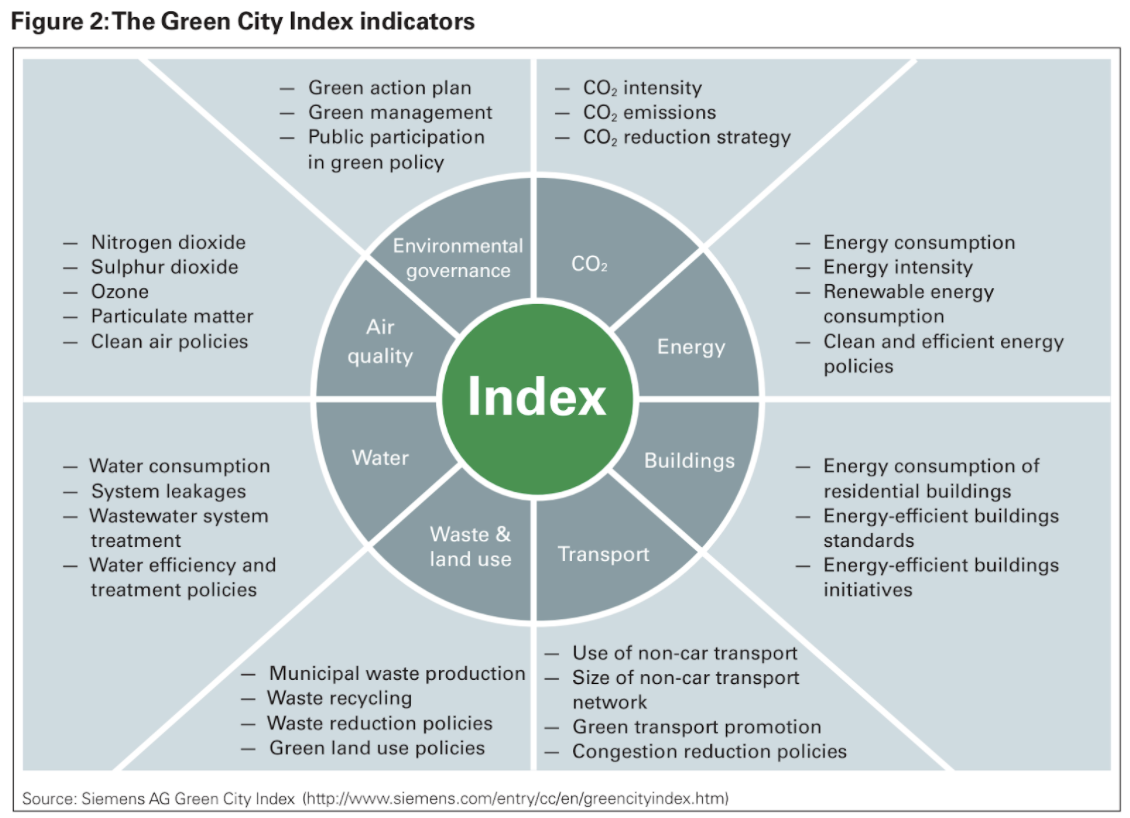



In [ ]:
d = {'Organization': city_df['Organization'].unique()}
df_green = pd.DataFrame(data=d)
city_country_dict = {}
city_region_dict = {}
for c in d['Organization']:
    city_country_dict[c] = city_df[city_df['Organization'] == c]['Country'].unique()[0]
    city_region_dict[c] = city_df[city_df['Organization'] == c]['CDP Region'].unique()[0]
df_green['Country'] = df_green['Organization'].map(city_country_dict)
df_green['CDP Region'] = df_green['Organization'].map(city_region_dict)

In [ ]:
def get_ans_unique_cnts(df,qnum):
    return len(get_ans(df, qnum).value_counts())

def separate_qs(df, axis):
    idx = [i[0] for i in axis]
    multichoice = []
    texts = []
    for i in idx:
        c = get_ans_unique_cnts(df, i)
        if(c < 10):
            multichoice.append(i)
        else:
            texts.append(i)
    return multichoice, texts

def get_ans_per_firm(df, qnum):
    qs = df['Question Name'].unique()
    return df[df["Question Name"] == qs[qnum]].groupby(['Organization'])["Response Answer"].apply(','.join).reset_index()

### Grading multiple choice problems and text answer problems differently

Some survey questions are multiple-choice format, where responders simply take one or more choices; while other questions are generally short answer quetions which require providing further information including, but not limited to, the nature of the risks/opportunities, what actions have been done/about to be done, among many others. We deal with these two sets of questions differently, as we compute:

- sentiment scores for short answer questions (i.e., narrative disclosures) using NLP processing
- numeric scores for multiple choice questions with weights for different options

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Sentiment analysis for short answer questions
def sentiment_score(df, axis, qnum_list):
    sid = SentimentIntensityAnalyzer()
    df[axis+'_score'] = 0
    
    for q_text in qnum_list:
        ans_df = get_ans_per_firm(city_df, q_text)
        df = pd.merge(df, ans_df[['Organization','Response Answer']],on='Organization', how='left')

        for i,ans in enumerate(df['Response Answer']):
            if type(ans) != str:
                df.loc[i,axis+'_score'] += 0        
            else:
                ss = sid.polarity_scores(ans)
                df.loc[i,axis+'_score'] += ss['compound'] + ss['pos']
        del df['Response Answer']
    return df

In [ ]:
def choice_score(df, axis, qnum_list):
#     df[axis+'_grade'] = 0
    options_map = {'Yes':2, 'No':0, 'Question not applicable': 0.5, 'Do not know':-0.5, \
              'In progress': 1.5, 'Intending to':1, "Not intending to": -1}
    
    for q_text in qnum_list:
        ans_df = get_ans_per_firm(city_df, q_text)
        ans_df[ans_df['Response Answer'].str.contains("Intending to")] = "Intending to"
        ans_df[ans_df['Response Answer'].str.contains("Not intending to")] = "Not intending to"
        df = pd.merge(df, ans_df[['Organization','Response Answer']],on='Organization', how='left')

        df[axis+'_score'] += ans_df["Response Answer"].map(options_map).fillna(0.1)
        del df['Response Answer']
    return df  

In [ ]:
# air quality axis
air = list(set(get_q(city_df,"air ")) | set(get_q(city_df,"gas")) | set(get_q(city_df,"Air")))
air_choice, air_texts = separate_qs(city_df, air)
df_green = sentiment_score(df_green, "air", air_texts)
df_green = choice_score(df_green, "air", air_choice)

In [ ]:
# governance axis
gov = list(set(get_q(city_df,"policy")) | set(get_q(city_df,"plan")) | set(get_q(city_df,"social")) | set(get_q(city_df,"eco")) | set(get_q(city_df,"employ")))
gov_choice, gov_texts = separate_qs(city_df, gov)
df_green = sentiment_score(df_green, "gov", gov_texts)
df_green = choice_score(df_green, "gov", gov_choice)

In [ ]:
# co2 axis
co2 = list(set(get_q(city_df,"CO2")) | set(get_q(city_df,"carbon")) | set(get_q(city_df,"GHG")) | set(get_q(city_df,"emission")))
co2_choice, co2_texts = separate_qs(city_df, co2)
df_green = sentiment_score(df_green, "co2", co2_texts)
df_green = choice_score(df_green, "co2", co2_choice)

In [ ]:
# energy axis
energy = list(set(get_q(city_df,"energy")))
energy_choice, energy_texts = separate_qs(city_df, energy)
df_green = sentiment_score(df_green, "energy", energy_texts)
df_green = choice_score(df_green, "energy", energy_choice)

In [ ]:
# building axis
building = list(set(get_q(city_df,"building")))
building_choice, building_texts = separate_qs(city_df, building)
df_green = sentiment_score(df_green, "building", building_texts)
df_green = choice_score(df_green, "building", building_choice)

In [ ]:
# extract quantitiative emission information
tCO2e = city_df.groupby('Question Name').get_group(qs_city[32]) # total CO2 emission
df = df_green.copy()
emit_list = []
for i in tCO2e['Row Number'].unique():
    CO2_div = tCO2e.groupby('Row Number').get_group(i).reset_index(drop = True)
    df = pd.merge(df,CO2_div[['Organization','Response Answer']],on='Organization', how='left')
    df.rename(columns = {'Response Answer':CO2_div['Row Name'][0] + '_emission'}, inplace = True)
    emit_list.append(CO2_div['Row Name'][0] + '_emission')
    
for i in range(len(emit_list)):
#     df.loc[df[emit_list[i]] == 'Question not applicable',emit_list[i]] = np.nan
    df[emit_list[i]] = pd.to_numeric(df[emit_list[i]], errors='coerce')
    
# df.fillna('Do not know', inplace = True)
df['totalCO2e'] = df[emit_list].sum(axis=1)
df['country_emit'] = df.groupby('Country')['totalCO2e'].transform('sum')
df['country_emit'] = df['country_emit'].replace(0, np.nan)

# emission map for all countries
import plotly.express as px

my_color_scale=cm.get_cmap("Greens",12)
fig = px.choropleth(df, locations="Country", locationmode='country names',color="country_emit", \
                    color_continuous_scale='Greys', hover_name="Country", range_color=[0,25],\
                    title = '2020 Emissions of CO2 per capita (metric tonnes) from buildings for Countries Surveyed by CDP <br><i>(only showing the ones that have valid submissions)<i>')

fig.update_layout(geo=dict(
    countrycolor= "#444444",
    showcountries=True))
fig.show()

In [ ]:
# transport axis
transport = list(set(get_q(city_df,"transport")) | set(get_q(city_df,"car")))
transport_choice, transport_texts = separate_qs(city_df, transport)
df_green = sentiment_score(df_green, "transport", transport_texts)
df_green = choice_score(df_green, "transport", transport_choice)

In [ ]:
# waste axis
waste = list(set(get_q(city_df,"waste")))
waste_choice, waste_texts = separate_qs(city_df, waste)
df_green = sentiment_score(df_green, "waste", waste_texts)
df_green = choice_score(df_green, "waste", waste_choice)

In [ ]:
# water axis
water = list(set(get_q(city_df,"water")))
water_choice, water_texts = separate_qs(city_df, water)
df_green = sentiment_score(df_green, "water", water_texts)
df_green = choice_score(df_green, "water", water_choice)

In [ ]:
# normalize scores along axis
from sklearn.preprocessing import MinMaxScaler, StandardScaler
for col in df_green.columns[3:]:
    scaler=MinMaxScaler()
    df_green[col] = scaler.fit_transform(df_green[[col]])

In [ ]:
# sum up all score
col_list = df_green.columns[3:]
df_green['sum'] = df_green[col_list].sum(axis=1)
scaler=MinMaxScaler()
df_green['sum'] = scaler.fit_transform(df_green[['sum']])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

axes = ['Air Quality','Environmental Governance','CO2','Energy','Buildings','Transport','Waste & Land use','Water']
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'polar'}]*1]*1)
city_list = list(df_green.nlargest(10, ['sum'])['Organization'])
print("Double click the legend to see individual contour!")

for c in city_list:
    city_grade = list(df_green[df_green["Organization"] == c].iloc[0,3:11])

    fig.add_trace(go.Scatterpolar(
          name = c,
          r = city_grade + [city_grade[0]],
          theta = axes + [axes[0]],
        ), 1, 1)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  font_size=12,
  legend_font_size=12,
  template = 'presentation',
  title = '<b>Top 10 Cities with Highest MGCI Score</b> <br><i>Double click the legend to see individual contour!</i>')
fig.show()

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'polar'}]*1]*1)
city_list2 = list(df_green.nsmallest(10, ['sum'])['Organization'])
for c in city_list2:
    city_grade = list(df_green[df_green["Organization"] == c].iloc[0,3:11])

    fig.add_trace(go.Scatterpolar(
          name = c,
          r = city_grade + [city_grade[0]],
          theta = axes + [axes[0]],
        ), 1, 1)

fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  font_size=12,
  legend_font_size=12,
  template = 'presentation',
  title = '<b>Top 10 Cities with Lowest MGCI Score</b> <br><i>Double click the legend to see individual contour!</i>')

fig.show()

In [ ]:
# emission map for all countries
import plotly.express as px

cols = ["Organization","air_score","gov_score","co2_score","energy_score","building_score",\
       "transport_score","waste_score","water_score","sum"]
df_grade = df_green[cols].melt(id_vars=["Organization"], 
        var_name="Score", 
        value_name="Value")
df_grade = pd.merge(df_grade, df_green[["Organization", "Country"]], on = 'Organization', how='left')

fig = px.choropleth(df_grade,locations="Country", locationmode='country names', color="Value",color_continuous_scale='Greens',
  animation_frame="Score", animation_group="Country", title = '2020 Modified Green City Index KPI Metric Score Distribution <br><i>- based on features extracted from CDP survey<i>')

fig.update_layout(geo=dict(
    countrycolor= "#444444",
    showcountries=True))
fig.show()

<div id="#3"></div>
<font color='#088a5a' size=5>3. Analysis on Corporate + City: CDP Answer Mining</font><br>            

In this section, we dive into the corporate survey data set and check whether there is any kind of synergy/collaborations with the city governments.


In [ ]:
corp_info = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Disclosing/Climate Change/2020_Corporates_Disclosing_to_CDP_Climate_Change.csv')
d = {'Organization': cc_df['organization'].unique()}
firm_green = pd.DataFrame(data=d)
qs = cc_df['Question Name'].unique()

mapping_country = dict(corp_info[['organization', 'country']].values)
mapping_industry = dict(corp_info[['organization', 'primary_industry']].values)
mapping_engage = dict(cc_df[cc_df["Question Name"] == qs[5]][["organization","Response Answer"]].values)
mapping_climate = dict(cc_df[cc_df["Question Name"] == qs[42]][["organization","Response Answer"]].values)
mapping_water = dict(cc_df[cc_df["Question Name"] == qs[96]][["organization","Response Answer"]].values)

firm_green['Country'] = firm_green['Organization'].map(mapping_country)
firm_green['Industry'] = firm_green['Organization'].map(mapping_industry)
firm_green['engage'] = firm_green['Organization'].map(mapping_engage)
firm_green['engage_climate'] = firm_green['Organization'].map(mapping_climate)
firm_green['engage_water'] = firm_green['Organization'].map(mapping_water)

In [ ]:
# extract quantitiative emission information
tCO2e = cc_df.groupby('Question Name').get_group(qs[21]) # total scope 1 CO2 emission in metric tons
tCO2e = tCO2e[(tCO2e["row_name"] == 'Reporting year') & (tCO2e["column_number"] == 1)]
tCO2e.rename(columns = {'organization': 'Organization'}, inplace = True)
# df = firm_green.copy()
firm_green = pd.merge(firm_green,tCO2e[['Organization','Response Answer']],on='Organization', how='left')
firm_green["Response Answer"] = pd.to_numeric(firm_green["Response Answer"], errors='coerce')
firm_green.rename(columns = {'Response Answer': 'totCO2'}, inplace = True)
qs[21]

In [ ]:
def recalc(df, col):
    d = df[col].value_counts()
    dd = {}
    for k,v in d.items():
        choices = [x.strip() for x in k.split(';')]
        for choice in choices:
            if choice in dd:
                dd[choice] += v
            else:
                dd[choice] = v
    return dd

In [ ]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# city vs. corporate risks
city_risk_q = [i[0] for i in get_q(city_df,"risk")]
city_risk_list = []
for q in city_risk_q:
    city_risk_list.append(' '.join([i for i in list(get_ans(city_df, q).unique()) if type(i) == str and \
                                    'http' not in i and 'de' not in i and 'please' not in i]))

city_risks = ' '.join([str(elem) for elem in city_risk_list]) 

# city_risks = combine_ans(city_df, "risk")
corp_risks = combine_ans(cc_df, "risk")
stopwords = set(STOPWORDS) 

fig = plt.figure()
fig.set_size_inches(20, 10)
colors_set = ['royalblue', 'indianred']
skills_list = [city_risks,corp_risks]
titles_list = ['City risks', 'Corporate risks']

for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    word_could_dict=skills_list[i]
    # Create wordcloud object
    wordcloud = WordCloud(width = 1200, height = 1200, background_color="white", stopwords = stopwords, 
                          color_func=lambda *args, **kwargs: colors_set[i], relative_scaling = 0.5).generate(word_could_dict)
    
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')

    # Set title
    ax.set_title(titles_list[i], size=48, pad=50)
    
plt.tight_layout(pad=0)
plt.show()

### City + Business Collaboration: what approaches are adopted?

In [ ]:
pref_color = ['#F7819F', '#F5A9BC', '#E6E6E6', '#CEF6D8', '#9FF781']
dds = [recalc(firm_green, "engage_climate"),recalc(firm_green, "engage_water")]
q = [42, 96]
for ii,dd in enumerate(dds):
    xx = sorted(list(dd.keys()))

    # matplotlib general settings
    fig, ax = plt.subplots(figsize=(35,1),frameon=False)
    plt.title("Q"+str(q[ii]) + ": " + qs[q[ii]], fontsize=28, loc='left')
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', labelsize=20, labelcolor='grey')  
    ax.set_facecolor('white')
    ax.axis('off')

    # Draw each bar and text separately with appropriate offset
    bar_start = 0
    cnts = [dd[_]/np.sum(list(dd.values())) for _ in xx]

    for i in range(len(dd)):
        ax.barh(y=['All Respondents'], width=cnts[i], height=0.1, left=bar_start, color=pref_color[i])
        plt.text(bar_start + cnts[i]/2 - 0.01, -0.01, "{:.0%}".format(cnts[i]), fontsize=20)
        bar_start += cnts[i]

#     Draw legend and set color of its text
    leg = ax.legend(xx, loc=(0,-0.5), ncol=5, fontsize=18, frameon=True, facecolor='white');
    for txt in leg.get_texts():
        plt.setp(txt, color='grey')

In [ ]:
from plotly.offline import init_notebook_mode, iplot
import matplotlib.colors as colors

# recalculate to account for multiple answers
dd1 = recalc(firm_green, "engage")
xx = list(dd1.keys())
xx = [_ + "<br>(" +str(round(100*dd1[_]/np.sum(list(dd1.values())),1))+ "%)" for _ in xx]
yy = [""]*len(dd1)
cc = list(colors._colors_full_map.values())

trace1 = go.Scatter(x = xx, y = [""]*len(dd1), mode='markers', name="", marker=dict(color=cc[:len(xx)], opacity=0.4, size = 0.2*np.array(list(dd1.values()))))
layout = go.Layout(barmode='stack', height=380, margin=dict(l=20), title="Approaches of corporate engagement on climate-related issues",
                   legend = dict(orientation="h", x=0.1, y=1.15), plot_bgcolor='#fff', paper_bgcolor='#fff', 
                   showlegend=False)

fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

# city engagement
dd = get_ans(city_df, 79).value_counts()[1:10]
xx = list(dd.keys())
xx = [_ + "<br>(" +str(round(100*dd[_]/dd.values.sum()))+ "%)" for _ in xx]
yy = [""]*len(dd)
cc = list(colors._colors_full_map.values())

trace1 = go.Scatter(x = xx, y = [""]*len(dd), mode='markers', name="", marker=dict(color=cc[:len(xx)], opacity=0.4, size = 0.2*np.array(list(dd.values))))
layout = go.Layout(barmode='stack', height=320, margin=dict(l=20), title="Approaches of city engagement with businesses",
                   legend = dict(orientation="h", x=0.1, y=1.15), plot_bgcolor='#fff', paper_bgcolor='#fff', 
                   showlegend=False)

fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [ ]:
vals = dd.values[:6]/100

In [ ]:
# flow chart
col_yes = "#fad46b"
col_no = "#97c6e8"
pfs = ["  Cities", "  Businesses"]

roles = list(dd.keys()[1:7])
ds = ["Collaboration"]

vals = list(dd.values[:6]/100)
# vals = [2.71, 2.3 , 1.72, 1.58, 1.39, 1.31]
vals2 = [1, 2.3, 1, 1.2, 0.9, 0.9]
sums = np.array(vals) + np.array(vals2)
vals += vals2


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 10,
      line = dict(color = "gray", width = 2),
      label =  pfs +  roles + ds,
      color = [col_yes, col_no] + ["#6ccc86"]*6
    ),
    link = dict(
      source = [0, 1]*len(roles) + [2,3,4,5,6,7]*len(ds),
      target = [2]*len(pfs) + [3]*len(pfs) + [4]*len(pfs) + [5]*len(pfs) + [6]*len(pfs) + [7]*len(pfs) + [8, 8, 8, 8, 8, 8],
      value = vals + list(sums)
  ))])


fig.update_layout(title_text='Major city-business collaboration pathways extracted from CDP survey',font=dict(size = 12),)
fig.show()

<div id="#4"></div>
<font color='#088a5a' size=5>4. Does setting up plans/targets promote sustainability performance?</font><br>            

In this part, we aim to provide empirical evidence on the determinants of sustainability performance.

In [ ]:
# CO2 emission by industry
co2_by_industry = firm_green.groupby('Industry')['totCO2'].sum()
co2_by_industry = dict(sorted(co2_by_industry.items(), key=lambda co2_by_industry: co2_by_industry[1])) # sorted

x_pos = [i for i, _ in enumerate(co2_by_industry)]

fig, ax = plt.subplots(figsize = (10,6))
plt.barh(x_pos, co2_by_industry.values(), color='green')
plt.ylabel("Industry")
plt.xlabel("CO2 Emissions (metric ton)")
plt.title("CO2 emission by industry",backgroundcolor='#cbe7e3',fontsize = 17)
ax.set_yticks(x_pos)
ax.set_yticklabels(co2_by_industry.keys(), rotation=0)
# plt.yticks(x_pos, x)
ax.grid(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
plt.show()

### Main Reasons for Not Having ...
- plans
- targets
- assessments

In [ ]:
q = set(get_q(city_df,"not have")) & set(get_q(city_df,"why")) #| set(get_q(city_df,"not"))
q = dict(q)
q

The responses to the above CDP questions provide a good secondary data source to split the responders into groups with or without early planning. 

In [ ]:
for k,val in q.items():
    options = city_df.groupby('Question Name').get_group(val)["Response Answer"].value_counts().keys()
    options_map = {}
    for i in np.arange(len(options)):
        options_map[options[i]] = i

    df_cityQ['q'+str(k)] = pd.DataFrame(city_df.groupby('Question Name').get_group(val)["Response Answer"]).reset_index(drop = True)
#     df_cityQ[k] = df_cityQ[k].map(options_map) # convert to numeric values

df_cityQ['CDP Region'] = df_cityQ['city'].map(city_region_dict)

In [ ]:
# Compare region distribution
# city_with_planning = list(df_cityQ[df_cityQ.iloc[:, 4:10].eq("Question not applicable").all(axis=1)]["city"])
city_wo_planning = list(df_cityQ[(df_cityQ.iloc[:, 4:10].eq("Question not applicable")).sum(axis=1) <5]["city"])
city_wo_planning = set(city_wo_planning) | set(list(df_cityQ[(df_cityQ.iloc[:, 4:10].eq("Do not know")).sum(axis=1) >= 2]["city"])) 
city_with_planning = [c for c in list(df_cityQ["city"]) if c not in city_wo_planning] 

dict_plan_city = df_cityQ[df_cityQ['city'].isin(city_with_planning)]['CDP Region'].value_counts()
dict_all_city = df_cityQ['CDP Region'].value_counts()
plan_cities = pd.DataFrame(dict_plan_city,index=dict_plan_city.keys())
all_cities = pd.DataFrame(dict_all_city)
COLORS_SET_B_G_R = [sns.color_palette('muted')[0], sns.color_palette('muted')[2], sns.color_palette('muted')[3]]

sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="CDP Region", y=all_cities.index, data=all_cities,
            label="Total", color="lightgrey")
sns.barplot(x="CDP Region", y=plan_cities.index, data=plan_cities, 
            label="Citis with sustainability plans", color=COLORS_SET_B_G_R[2], edgecolor='black')


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True, prop={'size': 10})
ax.set(xlim=(0, 180), ylabel="", xlabel="")

# Remove reduntant borders and labels
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.xaxis.set_label_text("# of cities")
ax.yaxis.set_label_text("CDP Region")
sns.despine(left=False, bottom=False)

# Set title and labels size
_ = ax.set_title('Number of Cities with Sustainable Planning across CDP surveys', fontsize=20, pad=25)
ax.tick_params(axis='y', which='major', labelsize=12)
_ = plt.setp(fig.patches, linewidth=0.5)

In [ ]:
def gen_xaxis(title):
    """
    Creates the X Axis layout and title
    """
    xaxis = dict(
            title=title,
            titlefont=dict(
                color='#AAAAAA'
            ),
            showgrid=False,
            color='#AAAAAA',
            )
    return xaxis


def gen_yaxis(title):
    """
    Creates the Y Axis layout and title
    """
    yaxis=dict(
            title=title,
            titlefont=dict(
                color='#AAAAAA'
            ),
            showgrid=False,
            color='#AAAAAA',
            )
    return yaxis
def gen_layout(charttitle, xtitle, ytitle, lmarg, h, annotations=None):  
    """
    Creates whole layout, with both axis, annotations, size and margin
    """
    return go.Layout(title=charttitle, 
                     height=h, 
                     width=800,
                     showlegend=False,
                     xaxis=gen_xaxis(xtitle), 
                     yaxis=gen_yaxis(ytitle),
                     annotations = annotations,
                     margin=dict(l=lmarg),
                    )
def gen_annotations(annot):
    """
    Generates annotations to insert in the chart
    """
    if annot is None:
        return []
    
    annotations = []
    # Adding labels
    for d in annot:
        annotations.append(dict(xref='paper', x=d['x'], y=d['y'],
                           xanchor='left', yanchor='bottom',
                           text= d['text'],
                           font=dict(size=13,
                           color=d['color']),
                           showarrow=False))
    return annotations

In [ ]:
df_cityQ["sustainable"] = "nan"
df_cityQ.loc[df_cityQ["city"].isin(city_wo_planning),"sustainable"] = False
df_cityQ.loc[df_cityQ["city"].isin(city_with_planning),"sustainable"] = True
df_green2 = pd.merge(df_green, df_cityQ[['city','sustainable']],left_on='Organization', right_on='city', how='left') 

x0 = df_green2[df_green2["sustainable"] == False]["sum"]
x1 = df_green2[df_green2["sustainable"] == True]["sum"]

# df2 = pd.merge(df,df_cityQ[['city','sustainable']],left_on='Organization', right_on='city', how='left') 
# x0 = df2[df2["sustainable"] == False]["totalCO2e"]
# x1 = df2[df2["sustainable"] == True]["totalCO2e"]

uneco_cities = go.Histogram(
    x=x0,
    opacity=0.5,
    marker={'color': 'lightgray'},
)
eco_cities = go.Histogram(
    x=x1,
    opacity=0.5,
    marker={'color': 'mediumaquamarine'},
)

annot_dict = [{'x': 0.2, 'y': 67, 'text': 'The less "sustainable" cities tend to get lower scores','color': 'gray'},
              {'x': 0.6, 'y': 25, 'text': '"Sustainable" city group tends to have<br>higher scores','color': 'mediumaquamarine'}]

layout = gen_layout('<b>Distribution of MGCI Scores of City Groups</b><br><i>Based on sustainable planning activities and risk awareness and/or preparations</i>', 
                    'Modified Green City Index (MGCI) Score',
                    'Quantity of Respondents',
                    annotations=gen_annotations(annot_dict),
                    lmarg=120, h=500
                    )
layout['barmode'] = 'overlay'

data = [uneco_cities, eco_cities]
layout = go.Layout(layout)
fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [ ]:
# Comparisons between cities with and without sustainable planning
fig, ax = plt.subplots(figsize=(5, 5))
COLORS_SET_B_G_R = [sns.color_palette('muted')[0], sns.color_palette('muted')[2], sns.color_palette('muted')[3]]

g = sns.barplot(x="sustainable", y="sum",
                data=df_green2, palette=COLORS_SET_B_G_R[1:3],
                dodge=True, ci=90, capsize=0.1, errwidth =1, edgecolor='black')

# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
# Set title
_ = ax.set_title('Average MGCI Scores for City Groups', fontsize=20, pad=25)
# Set x ticks
ax.tick_params(axis='x', which='major', labelsize=12)
_ = ax.xaxis.set_ticklabels(["Sustainable", "non-Sustainable"])
_ = plt.setp(g.patches, linewidth=0.5) 

### Clustering based on effects: Decision Trees

In [ ]:
# let us fit a decision tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_leaf_nodes=7, min_samples_leaf=5)
dt.fit(df_green2[df_green2.columns[3:11]], df_green2["sustainable"])

# let us plot a decision tree
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=df_green2.columns[3:11],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:

fig = go.Figure(data = [go.Bar(
            x=dt.feature_importances_[np.argsort(dt.feature_importances_)],
            y=list(df_green2.columns[3:11][np.argsort(dt.feature_importances_)]),
            orientation='h', marker=dict(color=COLORS_SET_B_G_R, opacity=0.1))], 
               layout = go.Layout(title="MGCI Axis Importances to Sustainable Preparedness", plot_bgcolor='#fff', paper_bgcolor='#fff',  margin=dict(l=100),
                               width=900, height=500, legend=dict(orientation="h", x=0.1, y=1.1)))
fig.show()

### Summarize the reasons

Let's take a brief look at why planning/assessments were not implemented.

In [ ]:
import bs4 as bs
import urllib.request
import re
import nltk
import heapq

excuses = combine_ans(city_df[city_df['Country'] == "United States of America"], ["why","not have"])
article_text = excuses

# Removing Square Brackets and Extra Spaces
article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)
article_text = re.sub(r'\s+', ' ', article_text)

# Removing special characters and digits
formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text )
formatted_article_text = re.sub(r'\s+', ' ', formatted_article_text)
sentence_list = nltk.sent_tokenize(article_text)
stopwords = nltk.corpus.stopwords.words('english')

word_frequencies = {}
for word in nltk.word_tokenize(formatted_article_text):
    if word not in stopwords:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1
    maximum_frequncy = max(word_frequencies.values())
    
for word in word_frequencies.keys():
    word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
    sentence_scores = {}
    
for sent in sentence_list:
    for word in nltk.word_tokenize(sent.lower()):
        if word in word_frequencies.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]
                    
summary_sentences = heapq.nlargest(10, sentence_scores, key=sentence_scores.get)

summary_sentences[0] = '- ' + summary_sentences[0] 
summary = '\n- '.join(summary_sentences)

print('\033[1m' + "Summary for reasons not planning for sustainability:" + '\033[0m')
print(summary)

<div id="#5"></div>
<font color='#088a5a' size=5>5. Concluding Remarks: Actionable Insights</font><br>            


Climate change and water stress is a present risk to business and cities alike.These environmental changes can give rise to many uncertainties and it is management’s responsibility to consider these uncertainties and how best to respond to them. Companies are increasingly expected to provide information and make relevant disclosures. 
 <br>
 
Our analysis draws upon the Green City Index framework and NLP analytics to construct a meaningful KPI for city development and to understand whether sustainability performance is driven by planning and preparedness. In extending the use of the generic approaches in this analysis, important policy implications could be derived. 
 <br>

Overall, the results from this exploratory imply two important insights:

**- Going Beyond Climate Change Risk Management**
 <br>
 
Whilst a growing number of firms start to take a more proactive stance on climate change, many firms are still adopting a "wait-and-see" approach. Our quantitative analyses show that greater awareness and preparedness is what sets superior performers apart. Qualitative content analysis confirm that superior performers provide more detailed description of climate change strategies that go beyond managing climate change risks. The results also support the importance of "command-and-control" legislations particularly for poor sustainability performers who are likely to react when environmental/social issues are perceived as a real threat through mandatory sanctions.
 <br> 

**- Seeking collaborative opportunities is exceedingly helpful**
 <br> 

 In the context of this study,  it is essential to prompt more companies to proactively seek innovative opportunities together with local government to address the challenges brought about by climate change. Voluntary proactive collaborations between business entities and governments could significantly boost sustainability performance.
 
  <br> 
The findings from this study, however, are subject to a numberof limitations. Data constraints may limit the validity of some variables. It is also important to acknowledge the inherent limitations of empirical analysis to capture the complexity of numerous dimensions included. Despite these constraints, the insights gathered from here can be useful as a springboard for future in-depth studies. 

<div id="#6"></div>
<font color='#088a5a' size=5>6. References</font><br>     

1. Summers, J. Kevin, et al. "Conceptualizing holistic community resilience to climate events: Foundation for a climate resilience screening index." GeoHealth 1.4 (2017): 151-164.
2. Dietz, Simon, et al. "An assessment of climate action by high-carbon global corporations." Nature Climate Change 8.12 (2018): 1072-1075.
3. Elijido-Ten, Evangeline O. "Does recognition of climate change related risks and opportunities determine sustainability performance?." Journal of cleaner production 141 (2017): 956-966.

Credits to [Teresa Kubacka](https://www.kaggle.com/tkubacka/a-story-told-through-a-heatmap) and [Shivam Bansal](https://www.kaggle.com/shivamb/spending-for-ms-in-data-science-worth-it) for awesome visualization ideas!